<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">22.418 · Aprenentatge automàtic</p>
<p style="margin: 0; text-align:right;">Grau en Ciència de Dades Aplicada</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis de Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Comparison of two algorithms

We will see in this notebook how we can compare the prediction accuracy of two algorithms.

In [1]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 7.1MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618281 sha256=a79e0b622062ac73b25967a6c24c33116953ba17fe1786de803e4c2f9c0a251c
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [2]:
from __future__ import (absolute_import, division, print_function,             
                        unicode_literals)                                      
import pickle
import os

import pandas as pd

from surprise import SVD
from surprise import KNNBasic
from surprise import Dataset                                                     
from surprise import Reader                                                      
from surprise.model_selection import PredefinedKFold
from surprise import dump
from surprise.accuracy import rmse

In [3]:
# We will train and test on the u1.base and u1.test files of the movielens-100k dataset.
# if you haven't already, you need to download the movielens-100k dataset
# You can do it manually, or by running:

Dataset.load_builtin('ml-100k')

# Now, let's load the dataset
train_file = os.path.expanduser('~') + '/.surprise_data/ml-100k/ml-100k/u1.base'
test_file = os.path.expanduser('~') + '/.surprise_data/ml-100k/ml-100k/u1.test'
data = Dataset.load_from_folds([(train_file, test_file)], Reader('ml-100k'))

pkf = PredefinedKFold()

                
# We'll use the well-known SVD algorithm and a basic nearest neighbors approach.
algo_svd = SVD()                                                       
algo_knn = KNNBasic()

for trainset, testset in pkf.split(data): 
    algo_svd.fit(trainset)                             
    predictions_svd = algo_svd.test(testset)
    
    algo_knn.fit(trainset)
    predictions_knn = algo_knn.test(testset)
    
    rmse(predictions_svd)
    rmse(predictions_knn)                                                                           
    
    dump.dump('./dump_SVD', predictions_svd, algo_svd)
    dump.dump('./dump_KNN', predictions_knn, algo_knn)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9512
RMSE: 0.9889


In [4]:
# The dumps have been saved and we can now use them whenever we want.

predictions_svd, algo_svd = dump.load('./dump_SVD')
predictions_knn, algo_knn = dump.load('./dump_KNN')

df_svd = pd.DataFrame(predictions_svd, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_knn = pd.DataFrame(predictions_knn, columns=['uid', 'iid', 'rui', 'est', 'details'])    

df_svd['err'] = abs(df_svd.est - df_svd.rui)
df_knn['err'] = abs(df_knn.est - df_knn.rui)

We now have two dataframes with the all the predictions for each algorithm. The cool thing is that, as both algorithm have been tested on the same testset, the indexes of the two dataframes are the same!

In [5]:
df_svd.head()

,uid,iid,rui,est,details,err
0,1,6,5.0,3.457603,{'was_impossible': False},1.542397
1,1,10,3.0,3.921446,{'was_impossible': False},0.921446
2,1,12,5.0,4.461500,{'was_impossible': False},0.538500
3,1,14,5.0,3.506826,{'was_impossible': False},1.493174
4,1,17,3.0,3.231391,{'was_impossible': False},0.231391


In [6]:
df_knn.head()

,uid,iid,rui,est,details,err
0,1,6,5.0,3.468613,"{'actual_k': 20, 'was_impossible': False}",1.531387
1,1,10,3.0,3.866290,"{'actual_k': 40, 'was_impossible': False}",0.866290
2,1,12,5.0,4.538194,"{'actual_k': 40, 'was_impossible': False}",0.461806
3,1,14,5.0,4.235741,"{'actual_k': 40, 'was_impossible': False}",0.764259
4,1,17,3.0,3.228002,"{'actual_k': 40, 'was_impossible': False}",0.228002


In [7]:
# Let's check how good are the KNN predictions when the SVD has a huge error:
df_knn[df_svd.err >= 3.5]

,uid,iid,rui,est,details,err
1912,38,257,1.0,3.989741,"{'actual_k': 40, 'was_impossible': False}",2.989741
1930,38,526,1.0,4.115078,"{'actual_k': 40, 'was_impossible': False}",3.115078
6512,141,1142,1.0,4.126349,"{'actual_k': 34, 'was_impossible': False}",3.126349
7390,167,169,1.0,4.664991,"{'actual_k': 40, 'was_impossible': False}",3.664991
13972,295,183,1.0,4.202611,"{'actual_k': 40, 'was_impossible': False}",3.202611
15306,312,265,1.0,4.131875,"{'actual_k': 40, 'was_impossible': False}",3.131875
19123,405,451,5.0,3.079841,"{'actual_k': 40, 'was_impossible': False}",1.920159
19140,405,575,5.0,2.410506,"{'actual_k': 36, 'was_impossible': False}",2.589494


In [8]:
# Well... Not much better.
# Now, let's look at the predictions of SVD on the 10 worst predictions for KNN
df_svd.iloc[df_knn.sort_values(by='err')[-10:].index]

,uid,iid,rui,est,details,err
9406,208,302,1.0,4.238209,{'was_impossible': False},3.238209
19089,405,169,1.0,2.795373,{'was_impossible': False},1.795373
19785,436,132,1.0,4.189851,{'was_impossible': False},3.189851
157,2,315,1.0,4.393061,{'was_impossible': False},3.393061
8503,193,56,1.0,3.825840,{'was_impossible': False},2.825840
5531,113,976,5.0,2.938536,{'was_impossible': False},2.061464
7917,181,408,1.0,2.964287,{'was_impossible': False},1.964287
7390,167,169,1.0,4.669191,{'was_impossible': False},3.669191
7412,167,1306,5.0,3.586421,{'was_impossible': False},1.413579
5553,114,1104,5.0,2.963408,{'was_impossible': False},2.036592


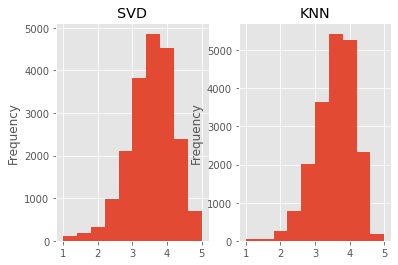

In [9]:
# How different are the predictions from both algorithms ?
# Let's count the number of predictions for each rating value

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline

matplotlib.style.use('ggplot')

figure, (ax1, ax2) = plt.subplots(1, 2)

df_svd.est.plot(kind='hist', title='SVD', ax=ax1)
df_knn.est.plot(kind='hist', title='KNN', ax=ax2)

# As expected, one of the drawbacks of the NN algorithms is that their predictions are often
# quite concentrated around the mean. The SVD algorithm seems more confortable predicting extreme rating values.

In [10]:
# Question: when a user has rated only a small number of items (less than 10), which algorithm
# gives the best predictions on average?

def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
df_knn['Iu'] = df_knn.uid.apply(get_Iu)
df_svd['Iu'] = df_svd.uid.apply(get_Iu)

df_knn[df_knn.Iu < 10].err.mean(), df_svd[df_svd.Iu < 10].err.mean()

(1.0382962702232328, 1.0119528664859407)